In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [32]:
def AR(phi, n):
    Lx = []
    x0 = 0
    for t in range(n):
        xt = phi*x0+np.random.normal(0,1)
        Lx.append(xt)
        x0 = xt
    return Lx

In [90]:
#초기값에 영향을 안받기 위해서 100을 추가해서 앞에꺼를 제거함
def AR1(phi0, phi1, n):
    L = []
    x0 = 0
    for t in range(100+n):
        xt = phi0+phi1*x0+np.random.normal(0, 1)
        L.append(xt)
        x0 = xt
    return L[100:]

In [69]:
def ARMA_22(phi0, phi1, phi2, th1, th2, ss, n):
    L = []
    w = np.random.normal(0, ss**0.5, n+2) #w[0], w[1],...,w[n+1]
    x00, x0 = 0, 0
    for t in range(2, n+2): #t=2,3,...,n+1 모두 n개
        xt = phi0 + phi1*x0 + phi2*x00 + w[t] +th1*w[t-1] + th2*w[t-2]
        L.append(xt)
        x00 = x0
        x0 = xt
    plt.plot(L)
    plt.show()
    return L

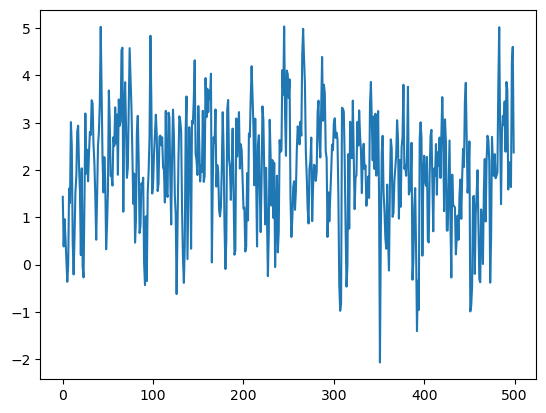

In [70]:
ar_1=AR1(3, 0.6,500)
ar_2=ARMA_22(1, 0.7, -0.2, 0, 0, 1, 500)

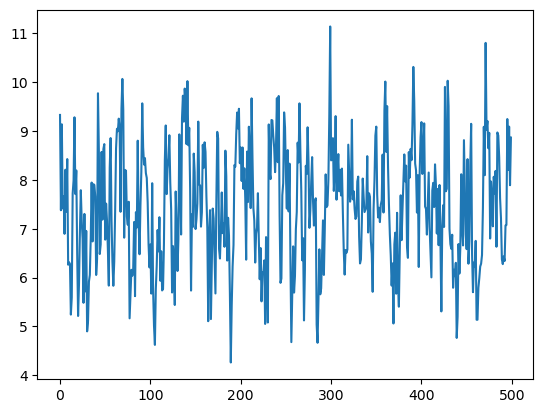

In [71]:
plt.plot(ar_1)
plt.show()

In [48]:
def OLSE_AR_1(D): # D=data
    n = len(D)
    X = np.array(D) - np.mean(D)
    L_num, L_den = [], []
    for t in range(1, n):
        L_num.append(X[t]*X[t-1])
        L_den.append(X[t-1]**2)
    olse = sum(L_num) / sum(L_den) # for phi = pih_1
    hat_phi0 = np.mean(D)*(1-olse) # mu = phi0 / (1-phi_1)
    hat_phi1 = olse
    return hat_phi0, hat_phi1

In [49]:
OLSE_AR_1(ar_1)

(-0.00245100763050033, 0.3374266284200753)

In [50]:
def ACF(D):
    x = D
    n = len(D)
    mu = np.mean(D)
    L = []
    for h in range(21): #h=0,1,2,...,20
        Lh = []
        for t in range(0, n-h):
            ac = (x[t+h] - mu)*(x[t]-mu)
            Lh.append(ac)
        autocov_h = sum(Lh)/n
        L.append(autocov_h)
    AutoCov = np.array(L)
    Sacf = AutoCov/AutoCov[0]
    plt.plot(Sacf, marker = 'o')
    y = [0 for t in range(21)]
    plt.plot(y, 'black')
    plt.show()
    return Sacf

In [51]:
def YW_AR_1(D):
    n = len(D)
    X = np.array(D) - np.mean(D)
    sacf = ACF(D)
#     sacf = sm.tsa.acf()
    hat_phi1 = sacf[1]
    hat_phi0 = np.mean(D)*(1-hat_phi1)
    return hat_phi0, hat_phi1

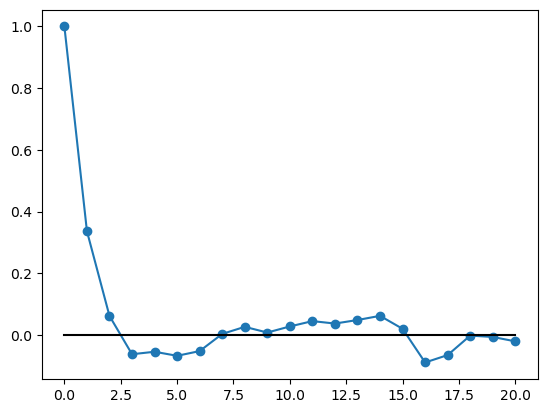

(-0.0024542420827182248, 0.33655226887726675)

In [52]:
YW_AR_1(ar_1)

In [92]:
def OLSE_AR_2(D): #xt=b`zt + wt where zt = (x_{t-1}, x_{t-2}, b =(b1, b2))
    n = len(D)
    X = np.array(D) - np.mean(D)
    Z, xx = [],[]
    for t in range(2, n):
        zt = [X[t-1], X[t-2]]
        Z.append(zt)
        xx.append(X[t])
    Z = np.array(Z)
    xx = np.array(xx) # hat_b =(Z`Z)^{-1}(Z`xx)
    First = np.dot(Z.T, Z) # T=transpose
    Second = np.dot(Z.T, xx)
    F_inv = np.linalg.inv(First)
    olse = np.dot(F_inv, Second)
    phi1, phi2 = olse
    phi0 = np.mean(D)*(1-phi1-phi2)
    return phi0, phi1, phi2

In [93]:
OLSE_AR_2(ar_2)

(1.0657252395766743, 0.6016138140317365, -0.12954494983817472)

# 이 부분부터 강의노트가 틀린 부분이 있음

In [43]:
def YW_AR_2(D): 
    n = len(D)
    X = np.array(D) - np.mean(D)
    rho = ACF(D) # AX=B  ==X=A^{-1}B
    B = np.zeros((2, 1))
    A = np.zeros((2, 2))
    for i in range(2): #i = 0, 1
        B[i][0] = rho[i+1]
        for j in range(2): #j=0,1
            if i >= j:
                A[i][j] = rho[i-j]
            else:
                A[i][j] = rho[j-i]
    A_inv = np.linalg.inv(A)
    phi = np.dot(A_inv, B)
    phi1, phi2 = phi
    phi0 = np.mean(D)*(1-phi1-phi2)
    return phi0, phi1, phi2

In [57]:
def FORE_AR1(D):
    mu = np.mean(D)
    print(mu)
    olse = OLSE_AR_1(D)
    print(olse) #phi0, phi1
    Xt = D[-1] # the last
    Xt1 = mu+olse[1]*(Xt-mu) # one-step forecast
    Xt2 = mu*olse[1]*(Xt1-mu) # two-step forecast
    Xt3 = mu+olse[1]*(Xt2-mu) # three-step forecast
    return Xt1, Xt2, Xt3

In [72]:
def Graph_FORE_AR1(D, ell):
    mu = np.mean(D)
    X = np.array(D) - mu
    olse = OLSE_AR_1(D) #phi0, phi1
    L = []
    Xt = D[-1] # the lst
    for k in range(1, ell+1): #k =1,2,3,....,ell (step forecast)
        fore_k = mu+olse[1]*(Xt-mu)
        L.append(fore_k)
        Xt=fore_k
    plt.plot(L)
    plt.show()
    return L

In [75]:
3/(1-0.6)

7.5

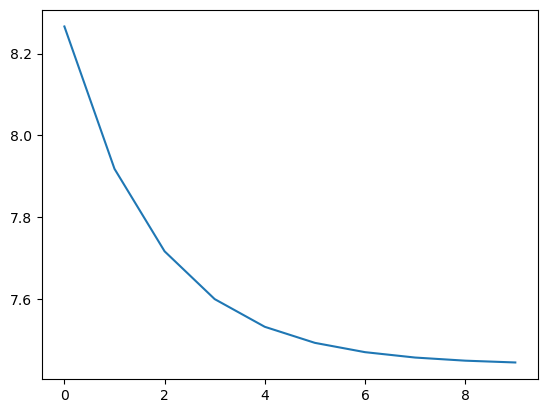

[8.26628990661217,
 7.918454832787191,
 7.716902722028836,
 7.600113886146263,
 7.532440905022492,
 7.493227975639558,
 7.470506147736356,
 7.457340044836443,
 7.449710981439362,
 7.445290340893019]

In [74]:
Graph_FORE_AR1(ar_1, 10)

In [96]:
def ERROR_one_step_forecast_AR1(D, m): #RMSE, MAE 강의노트 오류
    T = len(D)
    n = T-m
    Lr, Lf, Le = [], [], []
    for i in range(m): #i=0,1,...,m-1 총 m개
        INS = D[i:i+n] # of size n, from i, i+1, ....., i+n-1
        Real_one = D[i+n] # one-step real value
        mu = np.mean(INS)
        olse = OLSE_AR_1(INS) #phi0, phi1
        Xt = INS[-1] # the last
        Fore_one = mu+olse[1]*(Xt-mu)
        Lr.append(Real_one)
        Lf.append(Fore_one)
        Le.append(Real_one - Fore_one)
    Le = np.array(Le)
    MAE = np.mean(np.abs(Le))
    RMSE = (np.mean(Le**2))**0.5
    print(MAE, RMSE, '=MAE, RMSE')
    plt.plot(Lr, 'b', label='Real value', marker = 'o')
    plt.plot(Lf, 'r', label='Forecast', marker = '*')
    plt.legend()
    plt.show()
    return Lr, Lf

0.7572394847732491 1.0036716569431785 =MAE, RMSE


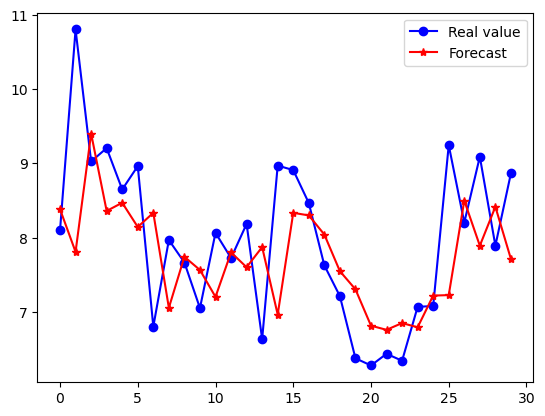

([8.096192264611615,
  10.804923823235189,
  9.02623741846232,
  9.205976614136427,
  8.648741029015914,
  8.963585162326988,
  6.800480963471502,
  7.9672302867506595,
  7.664493893311096,
  7.049916569348203,
  8.063968257731018,
  7.7243983088427015,
  8.184605942139438,
  6.631852677239603,
  8.970577200544794,
  8.910174327810754,
  8.466074577487968,
  7.6257541032074325,
  7.211025752002028,
  6.3736973314804635,
  6.276690814165026,
  6.434116210692921,
  6.340125724895264,
  7.066955144274691,
  7.078069366141114,
  9.246079628840304,
  8.202690578532257,
  9.090223839836057,
  7.891286515783055,
  8.866577535094939],
 [8.382727222154056,
  7.807567540699578,
  9.401640797144609,
  8.35924420241317,
  8.469848774277771,
  8.143227884517893,
  8.334207388045284,
  7.0538479488645285,
  7.741668336005212,
  7.563384704840622,
  7.201102249351189,
  7.800385591922749,
  7.6008794638732216,
  7.872256691699433,
  6.962986518541631,
  8.333750398846856,
  8.299341688868495,
  8.041

In [97]:
ERROR_one_step_forecast_AR1(ar_1, 30)

# 23.10.17실습

In [6]:
def ARIMA_1(phi, th, n, ss): #single unit root, ss=var of WN, ARIMA(110), ARIMA(111), ARIMA(011)
    ARMA_L = []
    w = np.random.normal(0, ss**0.5, n+1) # w[0], w[1],...,w[n]
    x0 = 0
    for t in range(1, n+1): # t=1,2,...,n
        xt = phi*x0+w[t]+th*w[t-1]
        ARMA_L.append(xt)
        x0 = xt
    Delta_Y = ARMA_L
    ARIMA_L = []
    for t in range(1, n+1):
        Yt = sum(Delta_Y[:t]) # 총 t개의 합
        ARIMA_L.append(Yt)
    return ARIMA_L

Arima111 = ARIMA_1(0.2, -0.7, 400, 1)
Arima110 = ARIMA_1(0.2, 0, 400, 1)
Arima011 = ARIMA_1(0, -0.7, 400, 1)

In [7]:
def Gr(D, T):
    plt.plot(D, 'b')
    plt.title(T)
    plt.show()

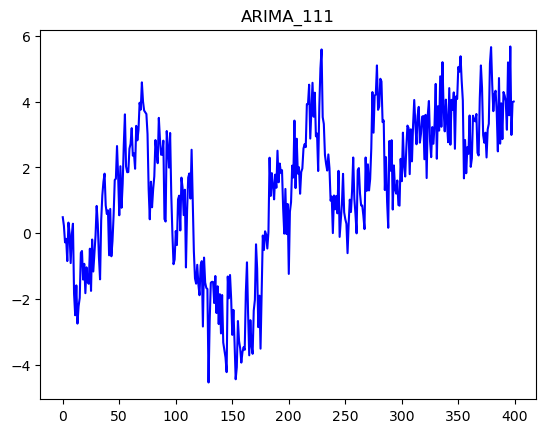

In [12]:
Gr(Arima111, 'ARIMA_111')

In [13]:

def DIFF(DATA):
    n = len(DATA)
    L = []
    X = DATA
    for t in range(1, n): # t=1,2,...,n-1
        Diff_t = X[t]-X[t-1]
        L.append(Diff_t)
    return L

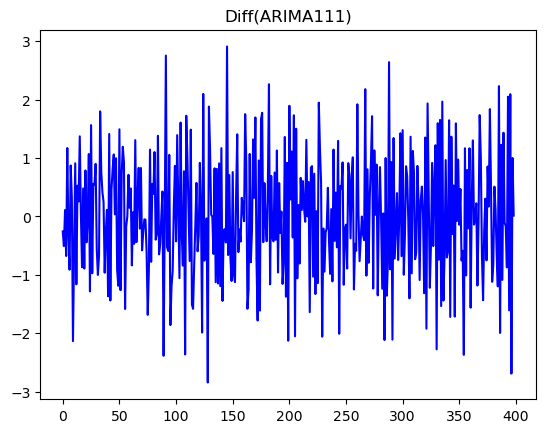

In [14]:
Gr(DIFF(Arima111), 'Diff(ARIMA111)')

In [15]:
def ARIMA_2(phi, th, n, ss): # two unit roots
    L1 = []
    w = np.random.normal(0, ss**0.5, n+1)
    x0 = 0
    for t in range(1, n+1):
        xt = phi*x0+w[t]+th*w[t-1]
        L1.append(xt)
    Delta2_Y = L1
    L2 = []
    for t in range(1, n+1):
        Dlt_t = sum(Delta2_Y[:t])
        L2.append(Dlt_t)
    Delta1_Y = L2
    L3 = []
    for t in range(1, n+1):
        Yt = sum(Delta1_Y[:t])
        L3.append(Yt)
    return L3

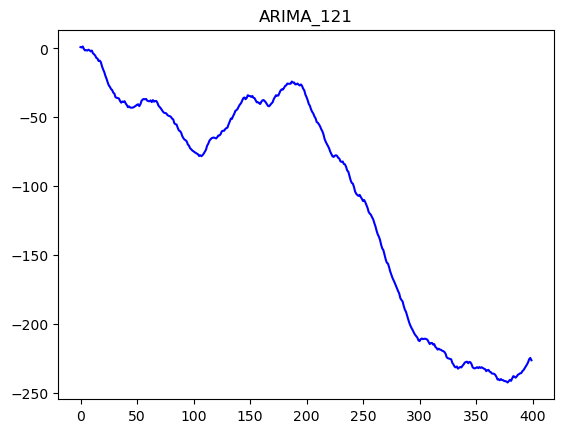

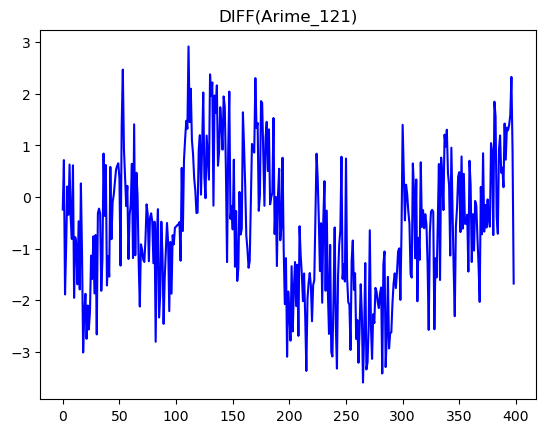

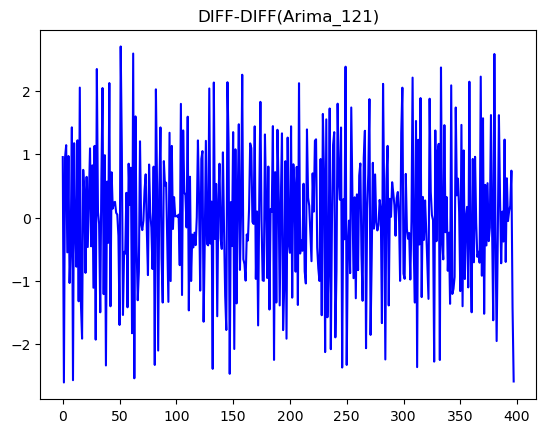

In [16]:
Arima_121 = ARIMA_2(0.2, -0.7, 400, 1)
Gr(Arima_121, 'ARIMA_121')
Gr(DIFF(Arima_121), 'DIFF(Arime_121)')
Gr(DIFF(DIFF(Arima_121)), 'DIFF-DIFF(Arima_121)')

In [18]:
def OLSE_AR_p(DATA, p): # Regression xt = b`zt+wt, zt = [x[t-1], x[t-2], ..., x[t-p]], b = (b1, b2, ..., b_p)
    n = len(DATA)
    X = np.array(DATA) - np.mean(DATA)
    Z, xx = [], []
    for t in range(p, n): # t=p, p+1, ..., n-1
        zt = []
        for j in range(1, p+1): # j = 1,2, ...., p
            zt_j = X[t-j]
            zt.append(zt_j) # zt = [x[t-1], x[t-2], ..., x[t-p]]
        Z.append(zt)
        xx.append(X[t])
    Z = np.array(Z)
    xx = np.array(xx) # olse = (Z`Z)^{-1}(Z`xx)
    F = np.dot(Z.T, Z)
    F_inv = np.linalg.inv(F)
    S = np.dot(Z.T, xx)
    olse = np.dot(F_inv, S)
    return olse

In [19]:
OLSE_AR_p(DIFF(Arima111), 30)

array([-0.46456876, -0.17087894, -0.18487244, -0.15673204, -0.21034615,
       -0.09522287, -0.05503072,  0.01468717, -0.0110449 , -0.0507151 ,
       -0.04714589, -0.00677148,  0.04064763,  0.00513255,  0.00333819,
       -0.01151595, -0.05815338, -0.07716465, -0.0080223 ,  0.11126399,
        0.04652704, -0.0168357 , -0.05005314, -0.03108166,  0.06039456,
        0.02520755, -0.05413944,  0.01336131, -0.09097309,  0.05292431])

In [21]:
OLSE_AR_p(DIFF(Arima111), 3)

array([-0.44078107, -0.12736672, -0.13066631])

In [22]:
OLSE_AR_p(DIFF(Arima111), 50)

array([-4.76786984e-01, -1.44477095e-01, -1.69690691e-01, -1.18116483e-01,
       -1.99365952e-01, -1.04113059e-01, -3.67021975e-02,  2.44285439e-02,
       -8.83350265e-04, -6.34707556e-02, -6.92634568e-02, -1.13445225e-02,
        3.24350417e-02,  1.44474158e-02,  1.99182101e-02, -2.75930121e-02,
       -4.62402191e-02, -9.29504421e-02, -2.43875117e-02,  1.17889050e-01,
        3.09983037e-02, -2.93998112e-02, -4.17183295e-02, -6.45718308e-03,
        7.48102517e-02,  2.53536525e-02, -4.82586586e-02,  3.14100872e-02,
       -7.97189649e-02,  5.76243035e-02,  4.38716415e-03, -8.31177493e-02,
        6.91729483e-03,  2.31100263e-02,  1.84793049e-02,  1.35109327e-02,
        2.53242630e-02,  2.32072205e-02, -3.26102260e-02,  1.62357112e-02,
        4.95040958e-02, -4.24273305e-02, -3.42693416e-02, -1.89829549e-03,
       -1.26018638e-03,  1.06689083e-01,  3.76144610e-04, -1.11382784e-01,
       -3.61863814e-02, -2.75194975e-02])

In [24]:
def Est_ARIMA(DATA, p): # DATA=ARIMA111
    Y = DATA
    Dlt_Y = DIFF(DATA) # st, inv ARMA(1, 1)
    X = Dlt_Y
    olse = OLSE_AR_p(X, p)
    print(olse[:4])
    th1 = olse[1]/olse[0]
    phi1 = olse[0]-th1
    return phi1, th1

In [25]:
Est_ARIMA(Arima111, 50)

[-0.47678698 -0.1444771  -0.16969069 -0.11811648]


(-0.7798092983654278, 0.3030223140574683)

In [26]:
Est_ARIMA(Arima111, 100)

[-0.51797135 -0.15798375 -0.20467766 -0.14280657]


(-0.8229761619492577, 0.3050048114461596)

In [27]:
Est_ARIMA(Arima111, 300)

[ 22.625  10.5    34.75  -32.125]


(22.160911602209946, 0.46408839779005523)

In [28]:
Est_ARIMA(Arima111, 200)

[-1.92504883 -1.18164062  0.4387207   0.59234619]


(-2.538872544041297, 0.6138237159162968)

In [29]:
Est_ARIMA(Arima111, 120)

[-0.52726276 -0.05882695 -0.18184325 -0.18148817]


(-0.6388332144526708, 0.11157045677649494)

In [30]:
from statsmodels.tsa.arima.model import ARIMA

In [31]:
model = ARIMA(Arima111, order=(1,1,1))

In [32]:
model_fit = model.fit()

In [33]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  400
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -552.512
Date:                Tue, 17 Oct 2023   AIC                           1111.024
Time:                        16:14:29   BIC                           1122.991
Sample:                             0   HQIC                          1115.764
                                - 400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1792      0.101      1.782      0.075      -0.018       0.376
ma.L1         -0.6413      0.079     -8.161      0.000      -0.795      -0.487
sigma2         0.9331      0.073     12.852      0.0